# Introduction

This project is sectioned into three parts:

1) Data Loading and Preprocessing
2) Baseline Model (Training, Testing, and Explanations with SHAP)
3) Adversarial Model (Definition, Training, Evaluation, and Explanation)

# Data Loading and Preprocessing

This project will rely on the [COMPAS scores dataset](https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv) published by ProPublica. Specifically, we will use the two years cleaned and filtered version, allowing for greater accuracy and precision.

In [20]:
import pandas as pd
import numpy as np

# Load dataset
compas = pd.read_csv('/Users/rishab/Downloads/compas-scores-two-years-dataset.csv')
print("Initial Shape:", compas.shape)

races = ['Caucasian', 'African-American']
compas = compas[compas['race'].isin(races)]
print("Shape with filtered races:", compas.shape)

Initial Shape: (7214, 53)
Shape with filtered races: (6150, 53)


In [10]:
# List of column names as a Python list of strings
columns = [
    "age",
    "sex",
    "race",
    "priors_count",
    "c_charge_degree",
    "c_charge_desc",
    "two_year_recid",
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
    "days_b_screening_arrest",
]

compas = compas[columns]
compas.shape

(6150, 11)

In [37]:
label_mapping = {
    'num__priors_count': 'Priors Count',
    'num__age': 'Age',
    'target_enc__c_charge_desc': 'Charge Description',
    'num__days_b_screening_arrest': 'Days Before Screening Arrest',
    'cat__sex_Female': 'Sex (Female)',
    'cat__sex_Male': 'Sex (Male)',
    'cat__race_African-American': 'Race (African-American)',
    'cat__race_Caucasian': 'Race (Caucasian)',
    'num__juv_other_count': 'Juvenile Count (Other)',
    'num__juv_fel_count': 'Juvenile Count (Felony)',
    'num__juv_misd_count': 'Juvenile Count (Misdemeanor)',
    'cat__c_charge_degree_F': 'Charge Degree (Felony)',
    'cat__c_charge_degree_M': 'Charge Degree (Misdemeanor)',
}

In [12]:
recid_rate = (compas["two_year_recid"] == 1).mean() * 100
print(f"Overall recidivism rate (is_recid=1): {recid_rate:.2f}%")

Overall recidivism rate (is_recid=1): 46.62%


In [14]:
count = compas[(compas["priors_count"] >= 1) & (compas["two_year_recid"] == 1)].shape[0]

print(count)

subset = compas[compas["priors_count"] >= 1]
proportion = (subset["two_year_recid"] == 1).mean()

print(f"Count: {count}, Proportion: {proportion:.2%}")

2346
Count: 2346, Proportion: 52.84%


In [16]:
numeric_features = [
    'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest'
]
categorical_features = [
    'sex', 'race', 'c_charge_degree'
]

target_encoder_features = ['c_charge_desc']

# Baseline Model

XGBClassifier will be utilized to predict recidivism within two years (binary target). Pipeline for preprocessing will be created to properly scale and encode numerical and categorical features.

Note: c_charge_desc will be target encoded due to high cardinality

In [32]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt
import shap

ModuleNotFoundError: No module named 'maplotlib'

In [34]:
print(xgb.__version__)
print(sklearn.__version__)
!python --version
print(np.__version__)
print(pd.__version__)
print(shap.__version__)
print(torch.__version__)

3.0.2
1.6.1
Python 3.12.4
1.26.4
2.2.2
0.46.0
2.4.0


In [21]:
y = compas['two_year_recid']
X = compas.drop(columns=['two_year_recid'])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('target_enc', TargetEncoder(), target_encoder_features)
])

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',       
        n_estimators=1000,           
        max_depth=4,                 
        learning_rate=0.03,          
        subsample=0.8,               
        colsample_bytree=0.8,        
        reg_alpha=0.1,               
        reg_lambda=1.0,              
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count',
                                                   'days_b_screening_arrest']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'race',
                                                   'c_charge_degree']),
                                                 ('target_enc...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [26]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score, log_loss, accuracy_score
import numpy as np
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "neg_log_loss": "neg_log_loss"
}

cv_results = cross_validate(
    pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

summary = {k: (np.mean(v), np.std(v)) for k, v in cv_results.items() if k.startswith("test_")}
for metric, (mean, std) in summary.items():
    print(f"{metric.replace('test_', ''):>12}: {mean:.4f} ± {std:.4f}")

    accuracy: 0.6732 ± 0.0098
     roc_auc: 0.7220 ± 0.0110
      pr_auc: 0.6966 ± 0.0083
neg_log_loss: -0.6322 ± 0.0085


Classification report:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       974
           1       0.68      0.58      0.62       871

    accuracy                           0.67      1845
   macro avg       0.67      0.67      0.67      1845
weighted avg       0.67      0.67      0.67      1845



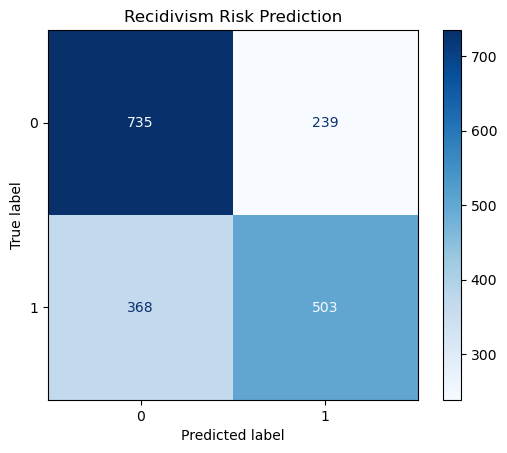

In [28]:
import matplotlib.pyplot as plt

y_base_pred = pipeline.predict(X_test)

print("Classification report:")
print(classification_report(y_test, y_base_pred))

cm_base = confusion_matrix(y_test, y_base_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm_base
).plot(cmap='Blues')
plt.title("Recidivism Risk Prediction")
plt.show()

### Auditing Fairness for Baseline Model

In [31]:
race_test = X_test['race'].values

results_baseline = pd.DataFrame({
    'race': race_test,
    'y_true': y_test,
    'y_pred': y_base_pred
})

In [33]:
dp_base = results_baseline.groupby('race')['y_pred'].mean()
print("Demographic Parity (Positive Prediction Rate) by Race:")
print(dp_base)

Demographic Parity (Positive Prediction Rate) by Race:
race
African-American    0.492793
Caucasian           0.265306
Name: y_pred, dtype: float64


In [35]:
def compute_group_errors(df):
    metrics = {}
    for race, g in df.groupby('race'):
        tn, fp, fn, tp = confusion_matrix(g['y_true'], g['y_pred'], labels=[0,1]).ravel()
        metrics[race] = {
            'FPR': fp/(fp+tn) if (fp+tn)>0 else 0,
            'FNR': fn/(fn+tp) if (fn+tp)>0 else 0
        }
    return pd.DataFrame(metrics).T

errs_base = compute_group_errors(results_baseline)
fpr_base = errs_base['FPR']
fnr_base = errs_base['FNR']
print(errs_base)

                       FPR       FNR
African-American  0.315488  0.349233
Caucasian         0.164080  0.573944


## Baseline SHAP

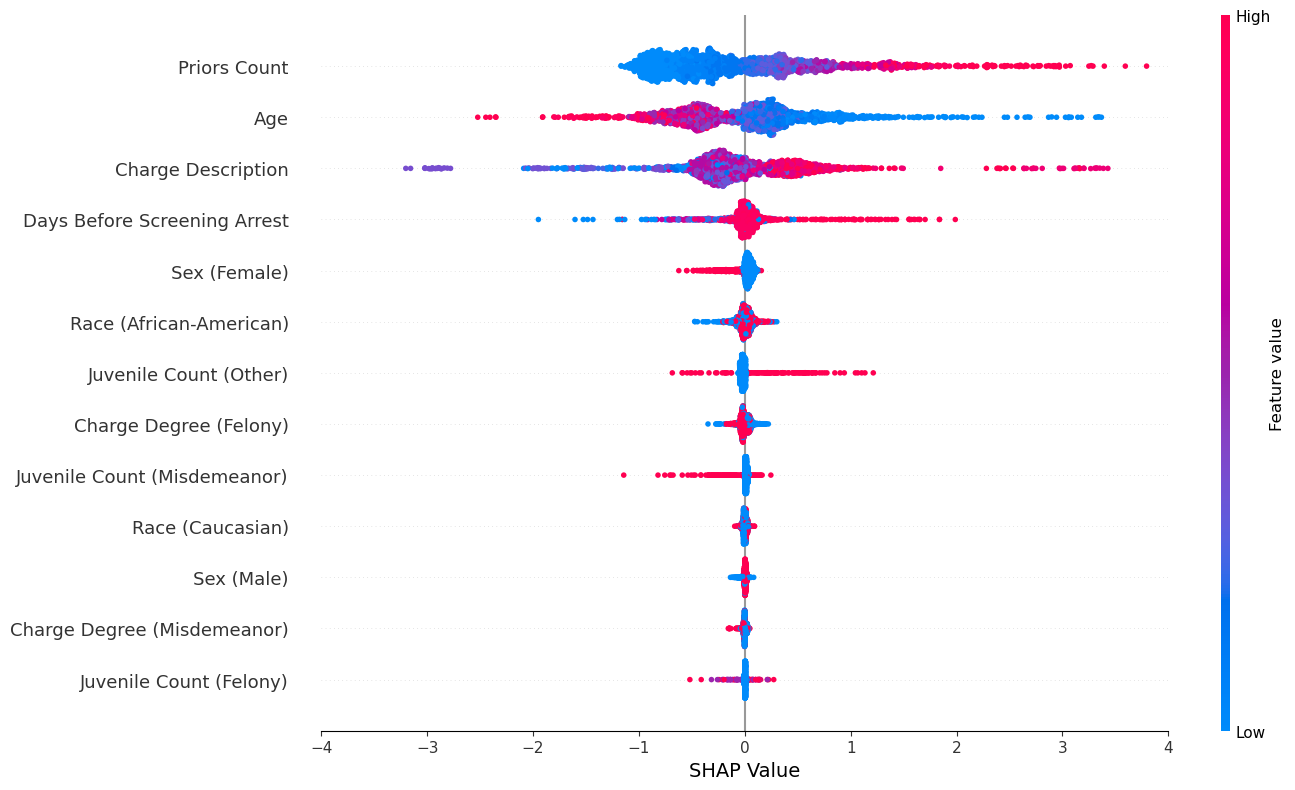

In [39]:
import shap

X_test_processed = pipeline.named_steps['preproc'].transform(X_test)
a = pipeline.named_steps['preproc'].get_feature_names_out()
feature_names = [label_mapping.get(feat, feat) for feat in a]

model = pipeline.named_steps['model']

explainer = shap.TreeExplainer(model)
shap_vals_base = explainer(X_test_processed)

shap.summary_plot(shap_vals_base, X_test_processed, feature_names=feature_names, show=False, plot_size=(14, 8))
fig = plt.gcf()
ax = plt.gca()
ax.set_xlim([-4, 4])  # Example: set x-axis limits
ax.set_xlabel("SHAP Value", fontsize=14)
fig.savefig("/Users/rishab/Desktop/figures/shap_beeswarm_plot_baseline.png", bbox_inches='tight', dpi=300)
plt.show()

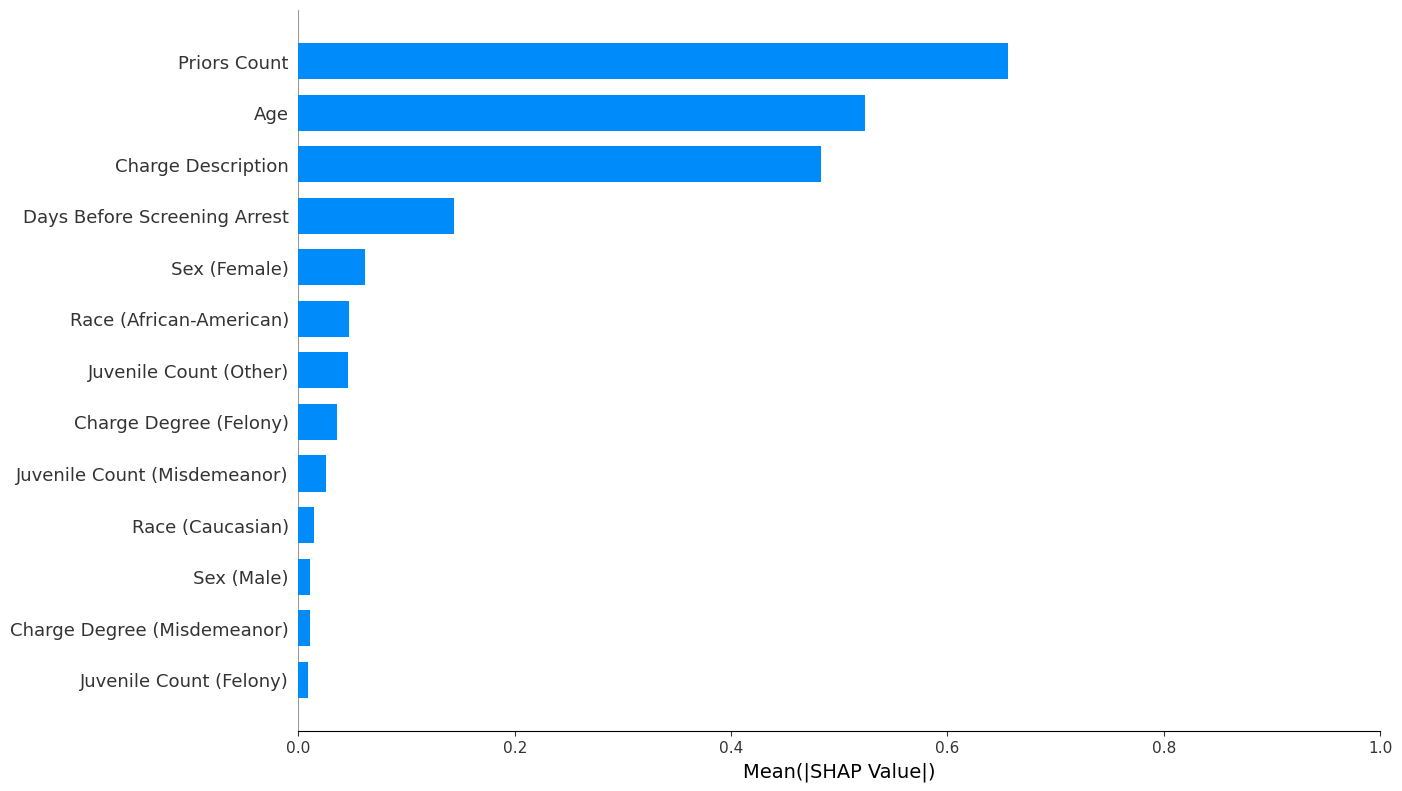

In [43]:
shap.summary_plot(shap_vals_base.values, feature_names=feature_names, show=False, plot_size=(14, 8), plot_type="bar")
fig = plt.gcf() 
ax = plt.gca()
ax.set_xlim([0, 1])  # Example: set x-axis limits
ax.set_xlabel("Mean(|SHAP Value|)", fontsize=14)
fig.savefig("/Users/rishab/Desktop/figures/shap_bar_plot_baseline.png", bbox_inches='tight', dpi=300)
plt.show()

# Adversarial Model

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [47]:
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class GradientReversalLayer(nn.Module):
    def __init__(self, alpha=1.0):
        super(GradientReversalLayer, self).__init__()
        self.alpha = alpha
    
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)

In [48]:
class PredictorNetwork(nn.Module):
    def __init__(self, input_dim):
        super(PredictorNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.network(x)

In [54]:
class AdversaryNetwork(nn.Module):
    def __init__(self, num_races=2):
        super(AdversaryNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, num_races)
        )
    
    def forward(self, x):
        return self.network(x)


In [56]:
class AdversarialModel(nn.Module):
    def __init__(self, input_dim, num_races=2, alpha=1.0):
        super(AdversarialModel, self).__init__()
        self.predictor = PredictorNetwork(input_dim)
        self.grl = GradientReversalLayer(alpha)
        self.adversary = AdversaryNetwork(num_races)
        
    def forward(self, x):
        logit = self.predictor(x)
        
        reversed_logit = self.grl(logit)
        
        race_pred = self.adversary(reversed_logit)
        
        return logit, race_pred

## Training Loop

In [59]:
def train_adversarial_model(X_train_processed, y_train, race_train,
                            epochs=200, alpha=2.0, lr=1e-4, batch_size=64,
                            return_losses=False, warmup=15, use_pos_weight=False):
    import torch, numpy as np
    from torch import nn, optim
    from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1)
    race_map = {'African-American': 0, 'Caucasian': 1}
    race_encoded = np.array([race_map[r] for r in race_train])
    race_train_tensor = torch.tensor(race_encoded, dtype=torch.long)

    model = AdversarialModel(X_train_tensor.shape[1], num_races=2, alpha=alpha).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    if use_pos_weight:
        pos = float((y_train_tensor.numpy()==1).sum())
        neg = float((y_train_tensor.numpy()==0).sum())
        pw = torch.tensor([neg/max(pos,1.0)], device=device)
        predictor_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pw)
    else:
        predictor_loss_fn = nn.BCEWithLogitsLoss()
    adversary_loss_fn = nn.CrossEntropyLoss()

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor, race_train_tensor)
    counts = np.bincount(race_encoded, minlength=2).astype(float)
    w = 1.0 / counts
    samp_w = w[race_encoded]
    sampler = WeightedRandomSampler(samp_w, num_samples=len(samp_w), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, drop_last=True)

    def ramp(e, T, a):
        e = min(max(e, 0), T)
        return a if T<=0 else a*(e/T)**2

    pred_losses, adv_losses = [], []

    for epoch in range(epochs):
        model.alpha = ramp(epoch, warmup, alpha)
        model.train()
        total_pred_loss = 0.0
        total_adv_loss = 0.0
        total_samples = 0

        for x_batch, y_batch, race_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            race_batch = race_batch.to(device)

            optimizer.zero_grad()
            logit, race_pred = model(x_batch)
            pred_loss = predictor_loss_fn(logit.view(-1), y_batch)
            adv_loss = adversary_loss_fn(race_pred, race_batch)
            total_loss = pred_loss + adv_loss
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            bsz = x_batch.size(0)
            total_pred_loss += pred_loss.item() * bsz
            total_adv_loss += adv_loss.item() * bsz
            total_samples += bsz

        pred_losses.append(total_pred_loss / total_samples)
        adv_losses.append(total_adv_loss / total_samples)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: pred={pred_losses[-1]:.4f} adv={adv_losses[-1]:.4f} alpha={model.alpha:.3f}")

        model.eval()
        with torch.no_grad():
            _ = model(X_train_tensor[:64].to(device))

    if return_losses:
        return model, race_map, {'pred_loss': pred_losses, 'adv_loss': adv_losses}
    else:
        return model, race_map

In [61]:
def evaluate_adversarial_model(model, X_test_processed, y_test, race_test, race_map, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Convert test data to tensors
        X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
        
        # Get predictions - NEW MODEL RETURNS (logit, race_pred)
        logit, _ = model(X_test_tensor)
        
        # Convert logit to probabilities using sigmoid
        y_pred_probs = torch.sigmoid(logit).cpu().numpy().flatten()
        y_pred = (y_pred_probs >= 0.5).astype(int)  # Using 0.5 threshold for now
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        
        # Encode race for fairness metrics
        race_encoded = np.array([race_map[race] for race in race_test])
        reverse_race_map = {v: k for k, v in race_map.items()}
        race_names = [reverse_race_map[race] for race in race_encoded]
        
        # Create results DataFrame
        results_df = pd.DataFrame({
            'race': race_names,
            'y_true': y_test,
            'y_pred': y_pred
        })
        
        return results_df, y_pred_probs, accuracy

In [63]:
def compute_fairness_metrics(df):
    records = []
    for race, grp in df.groupby('race'):
        tn, fp, fn, tp = confusion_matrix(grp['y_true'], grp['y_pred'], labels=[0,1]).ravel()
        fpr = fp / (fp + tn) if (fp+tn)>0 else 0.0
        fnr = fn / (fn + tp) if (fn+tp)>0 else 0.0
        records.append({'race': race, 'False Positive Rate': fpr, 'False Negative Rate': fnr, 'Count': len(grp)})
        
    return pd.DataFrame(records).set_index('race')

Epoch 0: pred=0.6509 adv=0.6917 alpha=0.000
Epoch 10: pred=0.5975 adv=0.6914 alpha=0.192
Epoch 20: pred=0.5929 adv=0.6914 alpha=0.768
Epoch 30: pred=0.5904 adv=0.6925 alpha=1.200
Epoch 40: pred=0.5735 adv=0.6911 alpha=1.200
Epoch 50: pred=0.5754 adv=0.6915 alpha=1.200
Epoch 60: pred=0.5670 adv=0.6909 alpha=1.200
Epoch 70: pred=0.5561 adv=0.6923 alpha=1.200
Epoch 80: pred=0.5669 adv=0.6936 alpha=1.200
Epoch 90: pred=0.5658 adv=0.6923 alpha=1.200
Epoch 100: pred=0.5513 adv=0.6920 alpha=1.200
Epoch 110: pred=0.5576 adv=0.6932 alpha=1.200
Epoch 120: pred=0.5449 adv=0.6922 alpha=1.200
Epoch 130: pred=0.5361 adv=0.6919 alpha=1.200
Epoch 140: pred=0.5474 adv=0.6939 alpha=1.200
Epoch 150: pred=0.5446 adv=0.6915 alpha=1.200
Epoch 160: pred=0.5384 adv=0.6918 alpha=1.200
Epoch 170: pred=0.5447 adv=0.6913 alpha=1.200
Epoch 180: pred=0.5368 adv=0.6902 alpha=1.200
Epoch 190: pred=0.5478 adv=0.6920 alpha=1.200
Epoch 200: pred=0.5347 adv=0.6931 alpha=1.200
Epoch 210: pred=0.5401 adv=0.6910 alpha=1.200

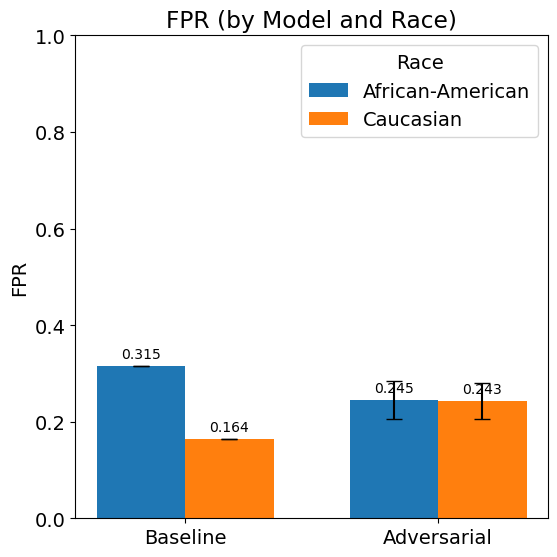

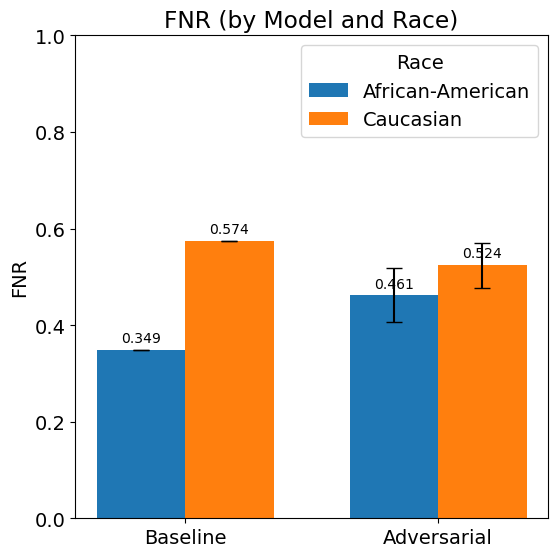

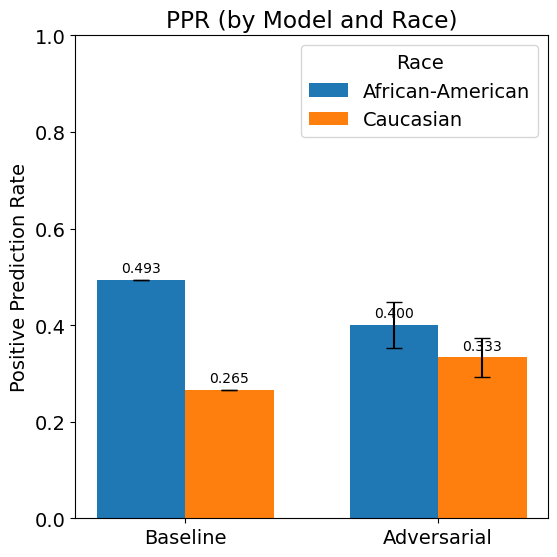

In [194]:
import numpy as np, random, torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from copy import deepcopy


SEEDS        = [1000 + i for i in range(10)]   # 10 adversarial trainings
THRESH       = 0.5                              # common decision threshold
RACE_ORDER   = ["African-American", "Caucasian"]  # display order to match your plots
BASELINE_SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def _rates(y_t, y_p):
    tn, fp, fn, tp = confusion_matrix(y_t, y_p, labels=[0,1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
    return fpr, fnr

def compute_group_metrics_df(y_true, y_pred_bin, race):
    rows = []
    for r in RACE_ORDER:
        mask = (race == r)
        fpr, fnr = _rates(y_true[mask], y_pred_bin[mask])
        ppr = y_pred_bin[mask].mean()  # P(h=1 | A=r)
        rows.append({"race": r, "FPR": fpr, "FNR": fnr, "PPR": ppr})
    return pd.DataFrame(rows).set_index("race")


def run_baseline_once():
    seed_everything(BASELINE_SEED)

    # Try to use the fitted pipeline directly
    try:
        proba = pipeline.predict_proba(X_test)[:, 1]
    except Exception:
        # Not fitted yet: try to rebuild and fit using the same preprocessor and model
        preproc = pipeline.named_steps['preproc']
        base_model = deepcopy(pipeline.named_steps['model'])
        # If the model has a random_state param, set it so the run is deterministic
        if hasattr(base_model, "random_state"):
            base_model.random_state = BASELINE_SEED
        base_pipe = Pipeline([('preproc', preproc), ('model', base_model)])
        base_pipe.fit(X_train, y_train)
        proba = base_pipe.predict_proba(X_test)[:, 1]

    y_pred = (proba >= THRESH).astype(int)
    metrics_df = compute_group_metrics_df(
        y_true=np.asarray(y_test).astype(int),
        y_pred_bin=y_pred,
        race=np.asarray(X_test['race'])
    )
    # For baseline we show no variation
    mean_df = metrics_df.copy()
    std_df  = metrics_df.copy() * 0.0
    return mean_df, std_df

def run_adversarial_once(seed: int):
    seed_everything(seed)

    preproc = pipeline.named_steps['preproc']   # reuse your preprocessing
    X_tr_proc = preproc.transform(X_train)
    X_te_proc = preproc.transform(X_test)

    model, race_map = train_adversarial_model(
        X_tr_proc,
        y_train,
        X_train['race'],
        epochs=300,
        alpha=1.2,
        lr=1e-4,
        batch_size=32,
        warmup=25,
        return_losses=False
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # evaluate_adversarial_model returns (results_df, y_pred_probs, acc)
    results_df, y_pred_probs, _ = evaluate_adversarial_model(
        model, X_te_proc, y_test, X_test['race'], race_map, device=device
    )

    y_pred_bin = (np.asarray(y_pred_probs) >= THRESH).astype(int)

    metrics_df = compute_group_metrics_df(
        y_true=np.asarray(y_test).astype(int),
        y_pred_bin=y_pred_bin,
        race=np.asarray(X_test['race'])
    )
    return metrics_df

def aggregate(stats_list):
    # list of DataFrames indexed by race with columns FPR,FNR,PPR
    stacked = pd.concat(stats_list, axis=0, keys=range(len(stats_list)))  # MultiIndex [run, race]
    mean = stacked.groupby(level=1).mean().loc[RACE_ORDER]
    std  = stacked.groupby(level=1).std(ddof=1).loc[RACE_ORDER]
    return mean, std

def plot_metric(metric_name, baseline_mean, baseline_std, adv_mean, adv_std, y_label=None):
    y_label = y_label or metric_name
    models = ["Baseline", "Adversarial"]
    x = np.arange(len(models))
    width = 0.35

    # bars are grouped by model, each bar corresponds to a race in RACE_ORDER
    # We will plot two sets: first race, then second race, as side-by-side bars per model.
    b_vals = baseline_mean[metric_name].values
    b_errs = baseline_std[metric_name].values
    a_vals = adv_mean[metric_name].values
    a_errs = adv_std[metric_name].values

    fig, ax = plt.subplots(figsize=(5.8,5.8))
    bars1 = ax.bar(x - width/2, [b_vals[0], a_vals[0]], width,
                   yerr=[b_errs[0], a_errs[0]], capsize=6, label=RACE_ORDER[0])
    bars2 = ax.bar(x + width/2, [b_vals[1], a_vals[1]], width,
                   yerr=[b_errs[1], a_errs[1]], capsize=6, label=RACE_ORDER[1])

    ax.set_title(f"{metric_name} (by Model and Race)")
    ax.set_xticks(x, models)
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel(y_label)
    ax.legend(title="Race", loc="upper right")

    # annotate bar heights
    for bars in (bars1, bars2):
        for b in bars:
            h = b.get_height()
            ax.text(b.get_x() + b.get_width()/2, h + 0.01, f"{h:.3f}",
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


baseline_mean, baseline_std = run_baseline_once()

adv_runs = [run_adversarial_once(s) for s in SEEDS]
adv_mean, adv_std = aggregate(adv_runs)

print("Baseline means:\n", baseline_mean.round(3))
print("Adversarial means (over seeds):\n", adv_mean.round(3))
print("Adversarial std (over seeds):\n", adv_std.round(3))

plot_metric("FPR", baseline_mean, baseline_std, adv_mean, adv_std, y_label="FPR")
plot_metric("FNR", baseline_mean, baseline_std, adv_mean, adv_std, y_label="FNR")
plot_metric("PPR", baseline_mean, baseline_std, adv_mean, adv_std, y_label="Positive Prediction Rate")

In [268]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_metric(metric_name, baseline_mean, adv_mean, adv_std,
                      palette=('#1f77b4', '#ff7f0e'),
                      figsize=(6,6),  # single-column friendly
                      save_dir=None,      # e.g., "figs"
                      filename_prefix="figure",
                      dpi=400):
    # data
    b_vals = baseline_mean.loc[RACE_ORDER, metric_name].values
    a_vals = adv_mean.loc[RACE_ORDER, metric_name].values
    a_errs = adv_std.loc[RACE_ORDER, metric_name].values

    df = pd.DataFrame({
        "Model": ["Baseline","Adversarial"] * 2,
        "Race":  [RACE_ORDER[0], RACE_ORDER[0], RACE_ORDER[1], RACE_ORDER[1]],
        metric_name: [b_vals[0], a_vals[0], b_vals[1], a_vals[1]],
        "err":  [0.0, a_errs[0], 0.0, a_errs[1]],
    })

    # style
    sns.set_theme(style="white", rc={"axes.grid": False})
    plt.rcParams.update({
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 10,
    })

    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(
        data=df,
        x="Model", y=metric_name, hue="Race",
        order=["Baseline","Adversarial"],
        hue_order=RACE_ORDER,
        palette=list(palette),
        errorbar=None, edgecolor=None, width=0.96
    )

    # axes and legend
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric_name if metric_name != "PPR" else "Positive Prediction Rate")
    leg = ax.legend(title="Race", loc="upper right", frameon=True, fancybox=False)
    leg.get_frame().set_edgecolor("black")
    leg.get_frame().set_linewidth(1.0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # error bars only on adversarial bars
    xticks = ax.get_xticks()          # [baseline_x, adversarial_x]
    x_adv  = xticks[1]
    bars = ax.patches                 # order: AA-Baseline, AA-Adversarial, C-Baseline, C-Adversarial
    adv_indices = [1, 3]
    for i, idx in enumerate(adv_indices):
        b = bars[idx]
        cx = b.get_x() + b.get_width()/2.0
        y  = b.get_height()
        ax.errorbar(cx, y, yerr=a_errs[i], fmt='none',
                    ecolor='black', elinewidth=1.2, capsize=4)

    plt.tight_layout()

    # saving
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        base = f"{filename_prefix}_{metric_name.lower()}"
        path = os.path.join(save_dir, f"{base}.png")
        fig.savefig(path, dpi=dpi, bbox_inches="tight")

    return fig, ax

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Model', ylabel='Positive Prediction Rate'>)

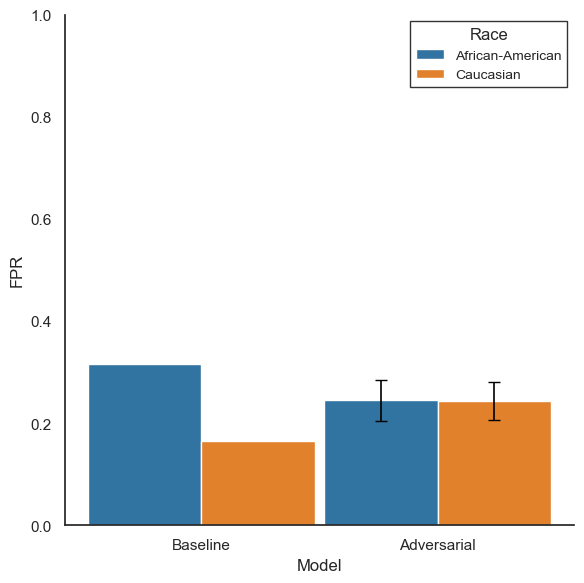

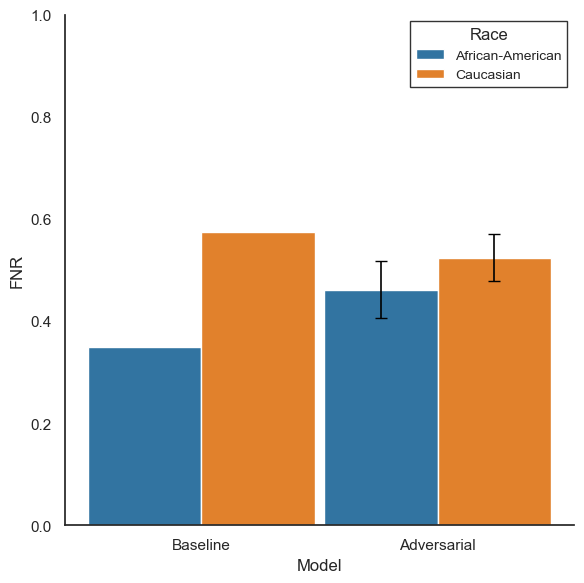

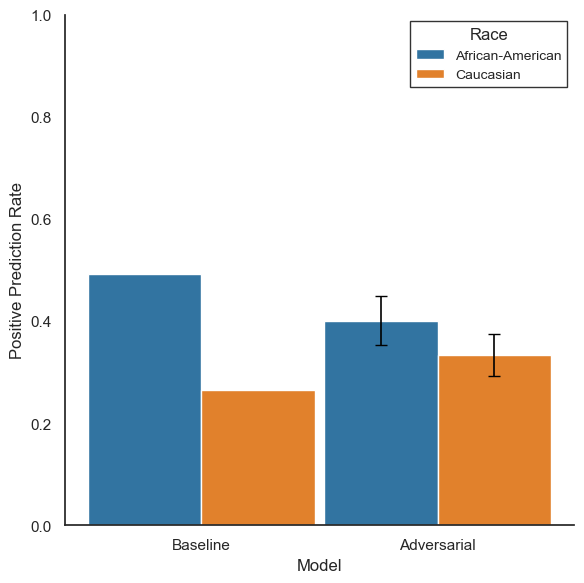

In [270]:
plot_metric("FPR", baseline_mean, adv_mean, adv_std, save_dir="/Users/rishab/Desktop/figures", filename_prefix="adv_vs_base")
plot_metric("FNR", baseline_mean, adv_mean, adv_std, save_dir="/Users/rishab/Desktop/figures", filename_prefix="adv_vs_base")
plot_metric("PPR", baseline_mean, adv_mean, adv_std, save_dir="/Users/rishab/Desktop/figures", filename_prefix="adv_vs_base")

In [170]:
# Train the model with chosen hyperparameters
print("Training Adversarial Model...")
X_train_processed = pipeline.named_steps['preproc'].transform(X_train)
 
adversarial_model, race_map, losses = train_adversarial_model(
    X_train_processed, 
    y_train, 
    X_train['race'], 
    epochs=300,
    alpha=1.2,
    lr=1e-4,
    batch_size=32,
    warmup=25,
    return_losses=True
)

print("Training completed!")

Training Adversarial Model...
Epoch 0: pred=0.6494 adv=0.6939 alpha=0.000
Epoch 10: pred=0.6072 adv=0.6939 alpha=0.192
Epoch 20: pred=0.5861 adv=0.6932 alpha=0.768
Epoch 30: pred=0.5854 adv=0.6918 alpha=1.200
Epoch 40: pred=0.5703 adv=0.6911 alpha=1.200
Epoch 50: pred=0.5653 adv=0.6916 alpha=1.200
Epoch 60: pred=0.5625 adv=0.6922 alpha=1.200
Epoch 70: pred=0.5565 adv=0.6935 alpha=1.200
Epoch 80: pred=0.5560 adv=0.6921 alpha=1.200
Epoch 90: pred=0.5484 adv=0.6921 alpha=1.200
Epoch 100: pred=0.5634 adv=0.6926 alpha=1.200
Epoch 110: pred=0.5518 adv=0.6927 alpha=1.200
Epoch 120: pred=0.5590 adv=0.6937 alpha=1.200
Epoch 130: pred=0.5466 adv=0.6929 alpha=1.200
Epoch 140: pred=0.5497 adv=0.6900 alpha=1.200
Epoch 150: pred=0.5441 adv=0.6923 alpha=1.200
Epoch 160: pred=0.5475 adv=0.6923 alpha=1.200
Epoch 170: pred=0.5459 adv=0.6911 alpha=1.200
Epoch 180: pred=0.5501 adv=0.6927 alpha=1.200
Epoch 190: pred=0.5387 adv=0.6916 alpha=1.200
Epoch 200: pred=0.5384 adv=0.6926 alpha=1.200
Epoch 210: pred

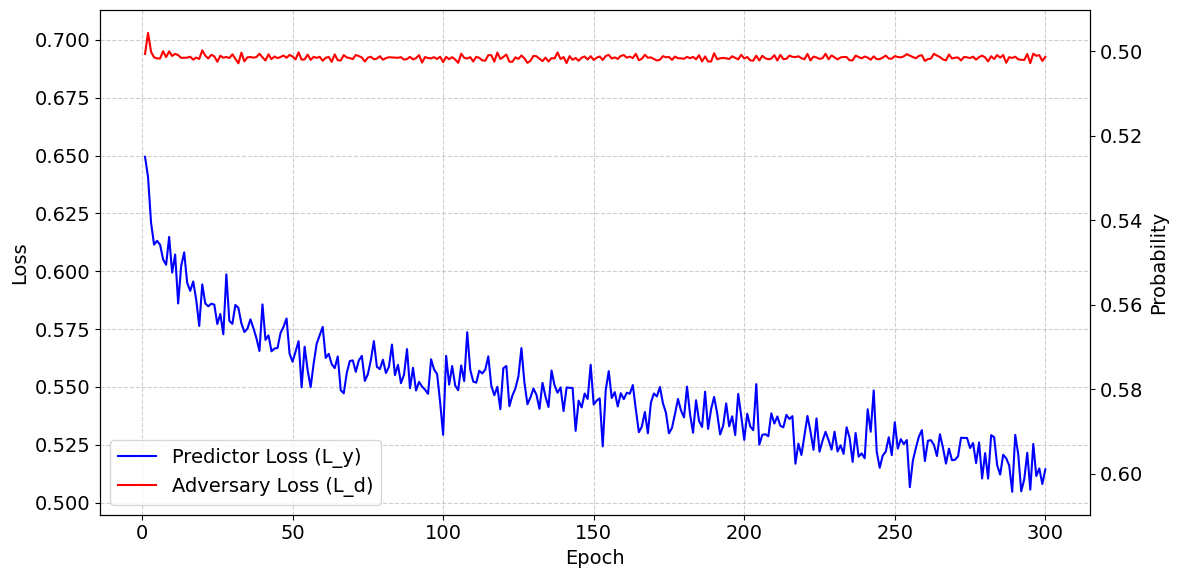

In [172]:
pred_loss = losses['pred_loss']
adv_loss = losses['adv_loss']
epochs = range(1, len(pred_loss) + 1)

# Create figure with primary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))
plt.rcParams.update({'font.size': 14})

# Plot on primary y-axis (loss values)
ax1.plot(epochs, pred_loss, label='Predictor Loss (L_y)', color='blue')
ax1.plot(epochs, adv_loss, label='Adversary Loss (L_d)', color='red')
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(axis='both', which='major', labelsize=14)

def loss_to_prob(loss):
    return np.exp(-loss)  # maps BCE loss → probability for y=1

ax2 = ax1.twinx()
ax2.set_ylabel('Probability', fontsize=14)
ax2.set_ylim(loss_to_prob(ax1.get_ylim()[0]), loss_to_prob(ax1.get_ylim()[1]))
ax2.tick_params(axis='y', which='major', labelsize=14)

plt.tight_layout()
plt.savefig('/Users/rishab/Desktop/figures/loss_probability_plot.png', dpi=300, bbox_inches='tight')

# Display the figure
plt.show()

In [174]:
# Run evaluation
X_test_processed = pipeline.named_steps['preproc'].transform(X_test)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adversarial_model = adversarial_model.to(device)

results_adversarial, y_pred_probs, adv_accuracy = evaluate_adversarial_model(
    adversarial_model, X_test_processed, y_test, X_test['race'], race_map, device
)

Accuracy: 0.6369


In [176]:
# Demographic Parity
dp_adv = results_adversarial.groupby('race')['y_pred'].mean()
errs_adv = compute_fairness_metrics(results_adversarial)
fpr_adv = errs_adv['False Positive Rate']
fnr_adv = errs_adv['False Negative Rate']

In [178]:
print("=== Adversarial Fairness Metrics ===")
print("Demographic Parity:\n", dp_adv.round(3))
print("\nError Rates:\n", errs_adv.round(3))

=== Adversarial Fairness Metrics ===
Demographic Parity:
 race
African-American    0.333
Caucasian           0.263
Name: y_pred, dtype: float64

Error Rates:
                   False Positive Rate  False Negative Rate  Count
race                                                             
African-American                0.184                0.533   1110
Caucasian                       0.188                0.620    735


In [180]:
base_dp_gap = abs(dp_base['African-American'] - dp_base['Caucasian'])
adv_dp_gap = abs(dp_adv['African-American'] - dp_adv['Caucasian'])
base_fpr_gap = abs(fpr_base['African-American'] - fpr_base['Caucasian'])
adv_fpr_gap = abs(fpr_adv['African-American'] - fpr_adv['Caucasian'])
base_fnr_gap = abs(fnr_base['African-American'] - fnr_base['Caucasian'])
adv_fnr_gap = abs(fnr_adv['African-American'] - fnr_adv['Caucasian'])
print(f"Baseline Model DP gap: {base_dp_gap:.3%}")
print(f"Adversarial Model DP gap: {adv_dp_gap:.3%}")
print(f"\nBaseline Model FPR gap: {base_fpr_gap:.3%}")
print(f"Adversarial Model FPR gap: {adv_fpr_gap:.3%}")
print(f"\nBaseline Model FNR gap: {base_fnr_gap:.3%}")
print(f"Adversarial Model FNR gap: {adv_fnr_gap:.3%}")

Baseline Model DP gap: 22.749%
Adversarial Model DP gap: 7.075%

Baseline Model FPR gap: 15.141%
Adversarial Model FPR gap: 0.491%

Baseline Model FNR gap: 22.471%
Adversarial Model FNR gap: 8.650%


In [182]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adversarial_model.to(device).eval()

def predict_fn(x_numpy):
    with torch.no_grad():
        x_t = torch.tensor(x_numpy, dtype=torch.float32).to(device)
        logits, _ = adversarial_model(x_t)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
    return probs

In [184]:
# Get model predictions (probabilities)
probs = predict_fn(X_test_processed)
preds = (probs > 0.5).astype(int)

# True labels
y_true = y_test if isinstance(y_test, np.ndarray) else np.array(y_test)

# Create confusion matrix
cm_adv = confusion_matrix(y_true, preds)

# Adversarial SHAP

  0%|          | 0/1845 [00:00<?, ?it/s]

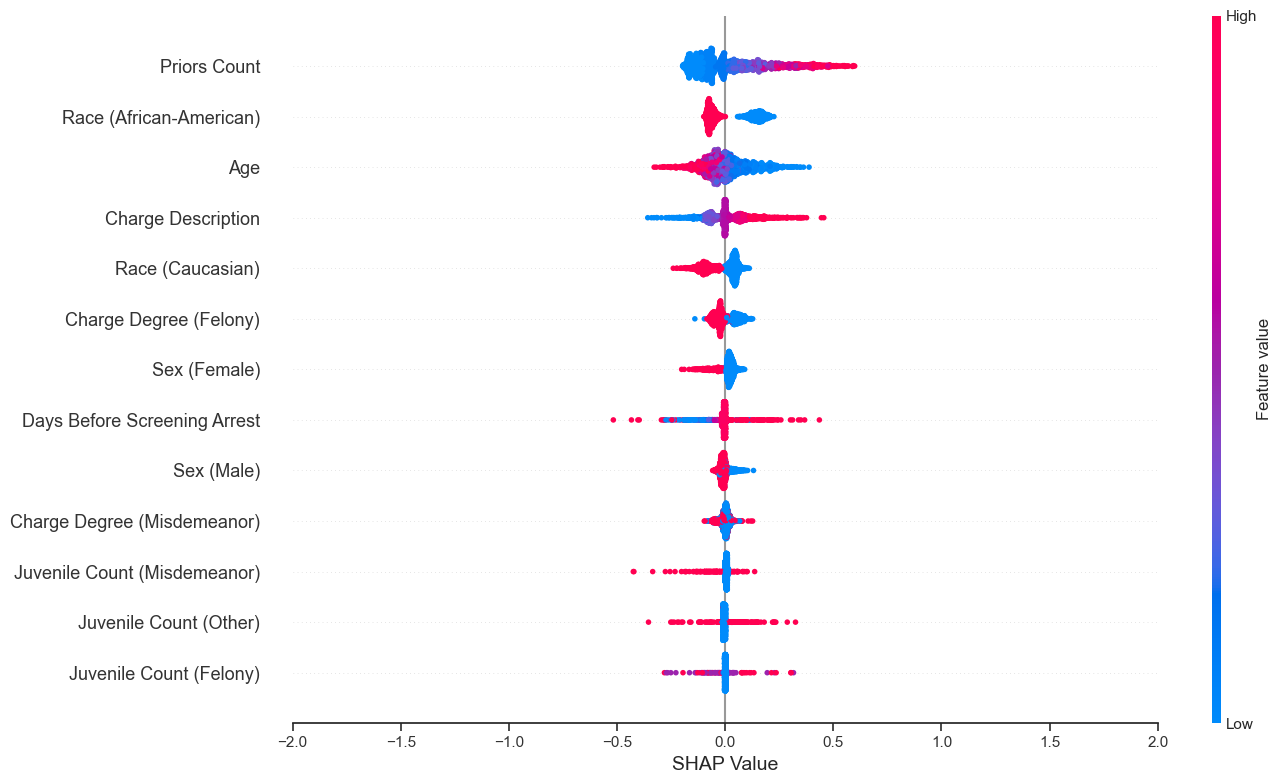

In [325]:

bg_idx = np.random.choice(X_train_processed.shape[0], 50, replace=False)
background = X_train_processed[bg_idx]

# Create a KernelExplainer with the background data
explainer = shap.KernelExplainer(predict_fn, background)

# Compute SHAP values on the test subset (use fewer samples for speed)
shap_values_subset = explainer.shap_values(X_test_processed)

plt.figure(figsize=(14, 8))

shap.summary_plot(
    shap_values_subset,      # SHAP values array shape (n_subset, n_features)
    X_test_processed,           # input data shape (n_subset, n_features)
    feature_names=feature_names,
    plot_size=(14, 8),
    show=False
)

ax = plt.gca()
ax.set_xlim(-2, 2)
ax.set_xlabel("SHAP Value", fontsize=14)

# Save the figure before showing it
plt.tight_layout()  # Adjust layout to make sure everything fits
plt.savefig('/Users/rishab/Desktop/figures/shap_summary_plot.png', dpi=300, bbox_inches='tight')

# Now display the plot
plt.show()

# Data Analysis

Now, we will compare the baseline and adversarial model side-by-side across various metrics to observe improvements.

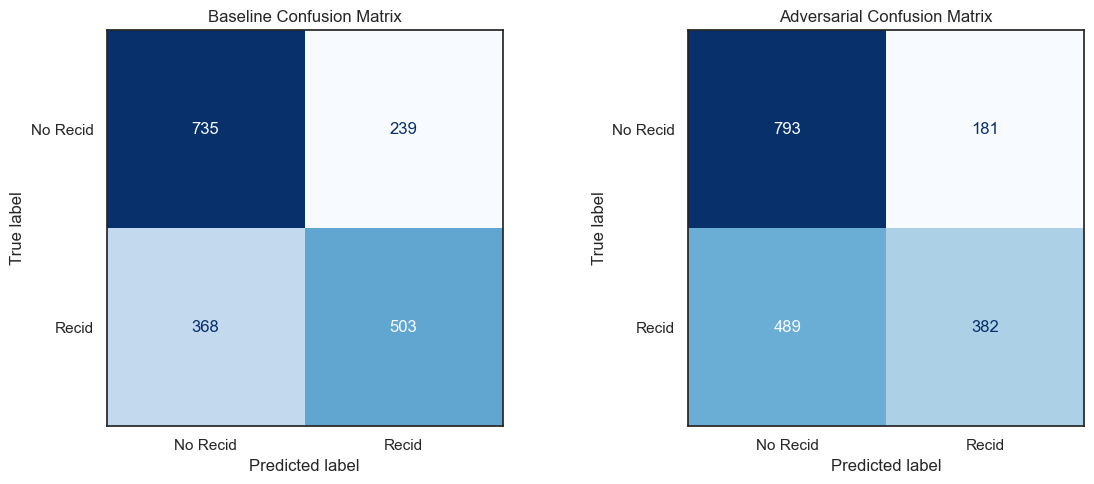

In [359]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

disp = ConfusionMatrixDisplay(cm_base, display_labels=['No Recid','Recid'])
disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Baseline Confusion Matrix')

# Adversarial
disp = ConfusionMatrixDisplay(cm_adv, display_labels=['No Recid','Recid'])
disp.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('Adversarial Confusion Matrix')

plt.tight_layout()
plt.show()

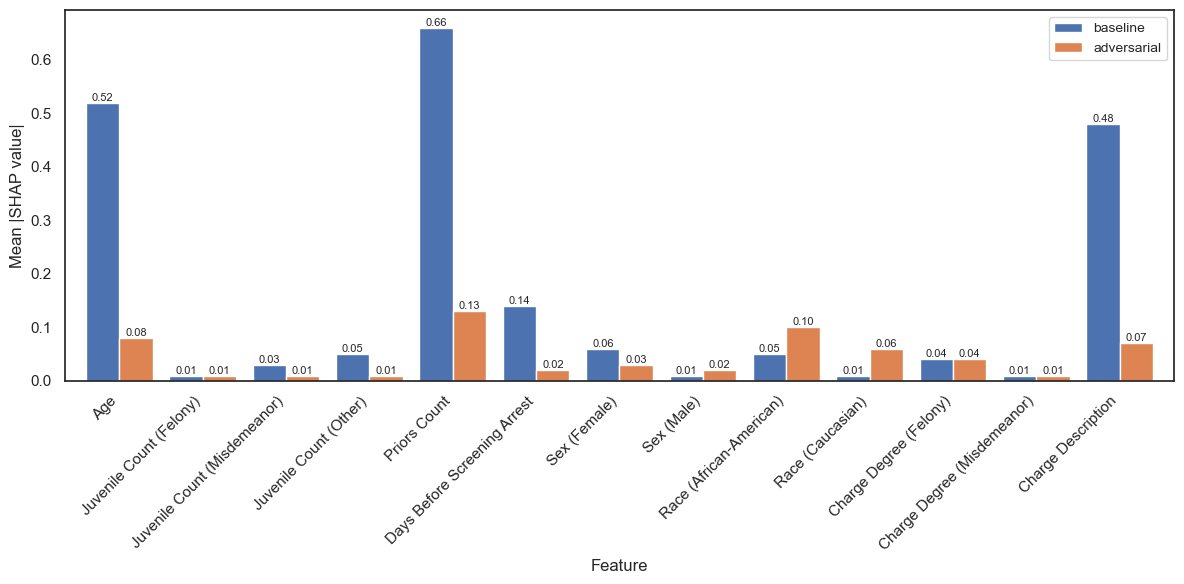

In [355]:
# 2. Extract SHAP values for baseline and adversarial on the same subset
shap_base_sub = shap_vals_base.values                    # (1500, n_features)
shap_adv_sub = shap_values_subset             # (1500, n_features)

# 3. Compute mean absolute SHAP per feature ensuring 1D arrays
mean_base = np.mean(np.abs(shap_base_sub), axis=0).flatten()
mean_adv = np.mean(np.abs(shap_adv_sub), axis=0).flatten()

# 4. Create DataFrame with 1D columns
df = pd.DataFrame({
    'feature': feature_names,
    'baseline': mean_base,
    'adversarial': mean_adv
})

df.set_index('feature', inplace=True)
df = df.round(2)

# 5. Plot bar chart
ax = df.plot.bar(figsize=(12, 6), width=0.8)
ax.set_xlabel('Feature')
ax.set_ylabel('Mean |SHAP value|')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=8)

plt.tight_layout()
plt.savefig('/Users/rishab/Desktop/figures/shap_values_compare.png', dpi=300, bbox_inches='tight')

plt.show()

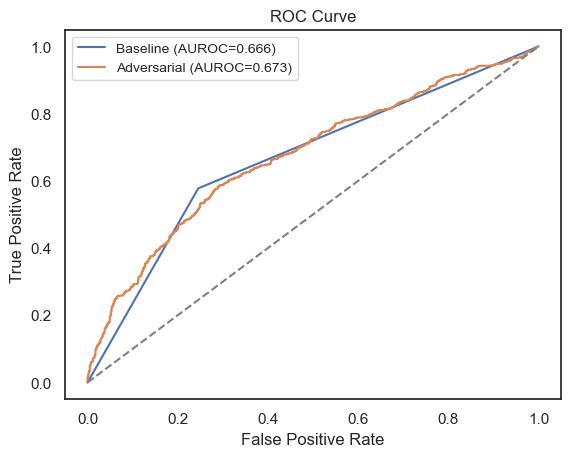

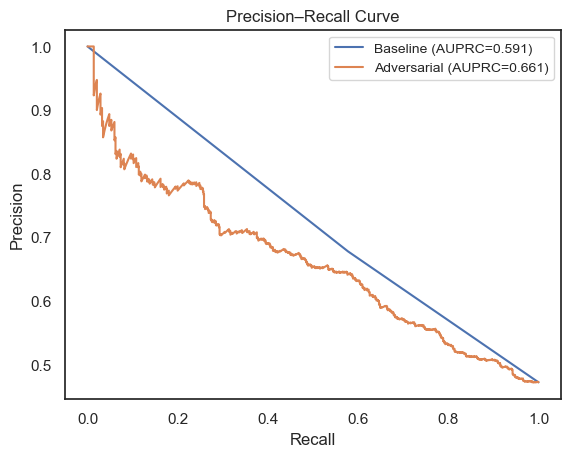

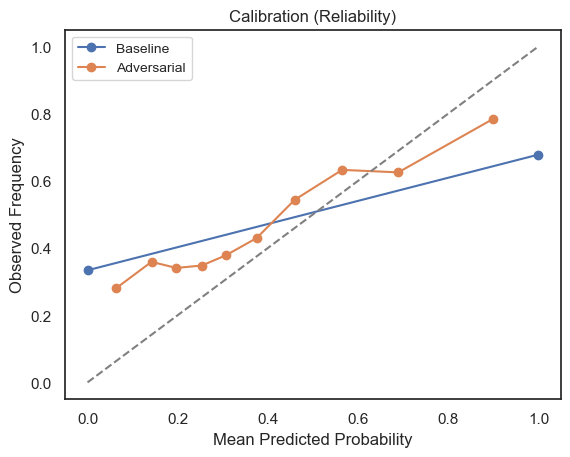

In [357]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# --- Make sure these exist ---
# y_test:       true labels (0/1)
# proba_base:   baseline model predicted probabilities
# proba_adv:    adversarial model predicted probabilities
# race_test:    sensitive attribute for fairness plots (e.g. 'African-American', 'Caucasian')

proba_base = y_base_pred
proba_adv = y_pred_probs

# 1) ROC curves
plt.figure()
for name, proba in [("Baseline", proba_base), ("Adversarial", proba_adv)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUROC={auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(); plt.show()

# 2) Precision–Recall curves
plt.figure()
for name, proba in [("Baseline", proba_base), ("Adversarial", proba_adv)]:
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(rec, prec, label=f"{name} (AUPRC={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(); plt.show()

# 3) Calibration curves
plt.figure()
for name, proba in [("Baseline", proba_base), ("Adversarial", proba_adv)]:
    frac_pos, mean_pred = calibration_curve(y_test, proba, n_bins=10, strategy='quantile')
    plt.plot(mean_pred, frac_pos, marker='o', label=name)
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Mean Predicted Probability"); plt.ylabel("Observed Frequency")
plt.title("Calibration (Reliability)")
plt.legend(); plt.show()

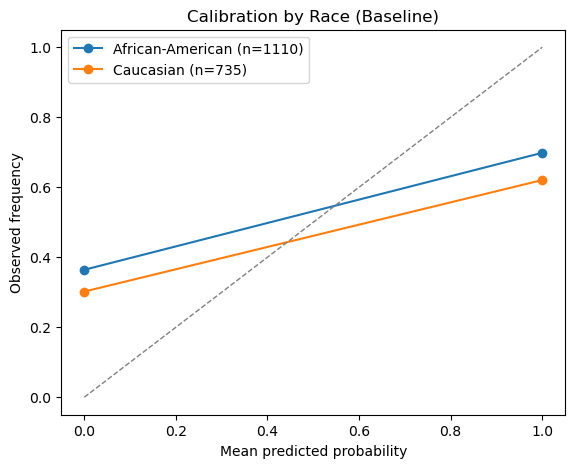

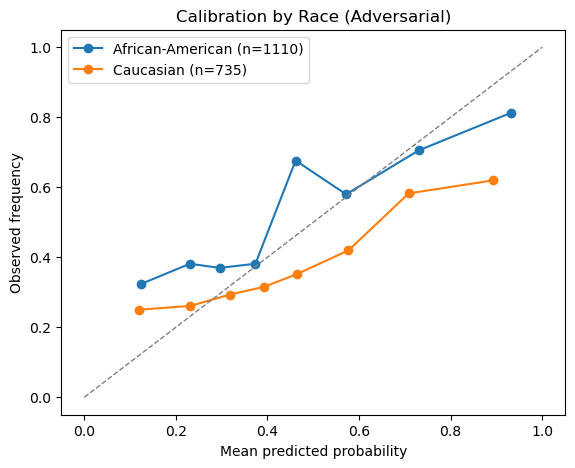

In [100]:
from sklearn.calibration import calibration_curve

# expects: y_test (0/1), race_test (array-like of str), proba_baseln, proba_adv

def plot_calibration_by_race(y, p, race, title, n_bins=8):
    races = pd.Series(race).astype(str).unique()
    plt.figure(figsize=(6.5,5))
    for r in races:
        mask = (race == r)
        if mask.sum() < n_bins*2:  # too few points -> skip to avoid noisy bins
            continue
        frac_pos, mean_pred = calibration_curve(y[mask], p[mask], n_bins=n_bins, strategy="quantile")
        plt.plot(mean_pred, frac_pos, marker="o", label=f"{r} (n={mask.sum()})")
    plt.plot([0,1],[0,1], "--", linewidth=1, color="gray")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(title)
    plt.legend()
    plt.show()

# Run one figure per model
plot_calibration_by_race(y_test, proba_base, race_test, title="Calibration by Race (Baseline)")
plot_calibration_by_race(y_test, proba_adv,    race_test, title="Calibration by Race (Adversarial)")

In [299]:
df = X_train[X_train["race"].isin(["African-American", "Caucasian"])].copy()
df.groupby("race")[["priors_count", "age"]].agg(["mean","median","std","count"])

priors_count                               age         \
                         mean median       std count       mean median   
race                                                                     
African-American     4.424981    2.0  5.618013  2586  32.527456   29.0   
Caucasian            2.668412    1.0  3.923823  1719  37.693426   35.0   

                                   
                        std count  
race                               
African-American  10.605983  2586  
Caucasian         12.860572  1719

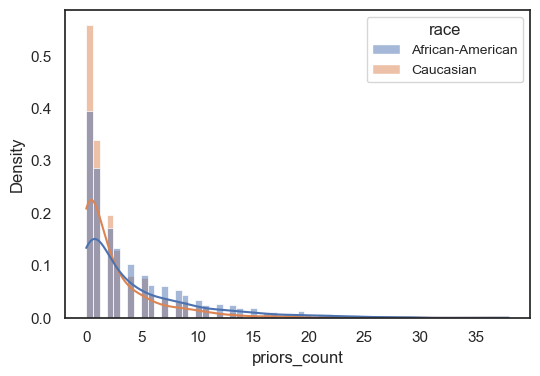

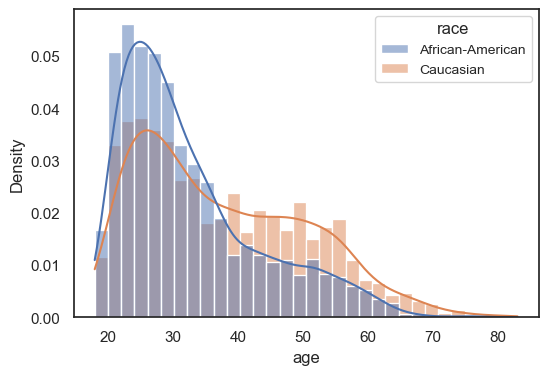

In [317]:
for col in ["priors_count", "age"]:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, hue="race", kde=True, stat="density", common_norm=False)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()